# Code used by both policies

First, some of their code:

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian import interpolate, grids, misc, estimation   # modules

def household_guess(a_grid,r,z_grid,gamma,T):
    new_z = np.ones((z_grid.shape[0],1))
    wel = (1 + r) * a_grid[np.newaxis,:] + new_z + T[:,np.newaxis]
    V_prime = (1 + r) * (wel * 0.1) ** (-gamma)
    return V_prime

@het(exogenous = 'Pi',policy = 'a', backward = 'V_prime', backward_init = household_guess)
def household(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta *(1+tauc)* V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r)/(1+tauc) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset])/(1+tauc)
        V_prime[indexes_asset] = (1 + r)/(1+tauc) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

def income(e_grid, w, N, taun):
    z_grid = (1 - taun) * w * N * e_grid
    return z_grid

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid, pi_e

def transfers(pi_e, Div, Transfer, e_grid):
    # hardwired incidence rules are proportional to skill; scale does not matter 
    tax_rule, div_rule = np.ones(e_grid.size), e_grid #np.ones(e_grid.size)
    div = Div / np.sum(pi_e * div_rule) * div_rule
    transfer =  (Transfer) / np.sum(pi_e * tax_rule) * tax_rule 
    T = div + transfer
    return T

hh_inp = household.add_hetinputs([make_grid,transfers,income])

@simple
def firm(Y, w, Z, pi, mu, kappa):
    N = Y / Z
    Div = Y - w * N - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return Div, N

@simple
def monetary(pi, rstar, phi_pi):
    r = (1 + rstar(-1) + phi_pi * pi(-1)) / (1 + pi) - 1
    return r

@simple
def fiscal(r, Transfer, B, C, N, tauc, taun, w):
    govt_res = Transfer + (1 + r) * B(-1) - tauc * C - taun * w * N - B
    return govt_res

@simple
def mkt_clearing(A, C, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    goods_mkt = Y - C - mu / (mu - 1) / (2 * kappa) * (1 + pi).apply(np.log) ** 2 * Y
    return asset_mkt, goods_mkt

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

@simple 
def union_ss(w, N, UCE, kw, v, muw, tauc, taun):
    phi = ((1 - taun) * w * N ** (-v) * UCE) / ((1 + tauc) * muw) # our formula
    wnkpc = kw * (phi * N ** (1 + v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw))
    return wnkpc, phi

@simple
def wage(pi, w):
    piw = (1 + pi) * w / w(-1) - 1
    return piw

@simple
def union(piw,w,N,UCE,kw,phi,v,muw,beta,tauc,taun):
    wnkpc = (kw * (phi * N ** (1+v) - (1 - taun) * w * N * UCE / ((1 + tauc) * muw)) 
             + beta * (1 + piw(+1)).apply(np.log) - (1 + piw).apply(np.log))
    return wnkpc

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

The code bellow takes care of the iteration for finding the policies for the household:

In [2]:
def household_d(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc):

    c_prime = (beta * V_prime_p) ** (-1/gamma) # c_prime is the new guess for c_t

    new_grid = (1 + tauc) * c_prime + a_grid[np.newaxis,:] - z_grid[:,np.newaxis] - T[:,np.newaxis]
    wel = (1 + r) * a_grid

    c = interpolate.interpolate_y(new_grid,wel,c_prime)

    a = wel + z_grid[:,np.newaxis] + T[:,np.newaxis] - (1 + tauc) * c
    V_prime = (1 + r) * c ** (-gamma)

    # checks for violations of the condition of minimal assets required and fixes it
    indexes_asset = np.nonzero(a < a_grid[0]) #first dimension: labor grid, second dimension: asset grid
    if indexes_asset[0].size != 0 and indexes_asset[1].size !=0:
        
        a[indexes_asset] = a_grid[0]
        c[indexes_asset] = (wel[indexes_asset[1]] + z_grid[indexes_asset[0]] 
                            + T[indexes_asset[0]] - a[indexes_asset])/(1+tauc)
        V_prime[indexes_asset] = (1 + r) * (c[indexes_asset]) ** (-gamma)
        
    uce = e_grid[:,np.newaxis] * c ** (-gamma)

    return V_prime,a,c,uce

def iterate_household(foo,V_prime_start,Pi,a_grid,w,N,taun,pi_e,e_grid,r,Div,Transfer,beta,gamma,v,tauc,maxit = 1000,tol = 1E-8):
    
    V_prime_p = Pi@V_prime_start
    V_prime_old = V_prime_start
    #_,_,c,_ = foo(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc)
    
    ite = 0
    err = 1
    
    T = transfers(pi_e, Div, Transfer, e_grid)
    z_grid = income(e_grid, w, N, taun)
    
    while ite < maxit and err > tol:
        
        #c_old = np.copy(c)
        V_prime_temp,a,c,uce = foo(V_prime_p,a_grid,z_grid,e_grid,r,T,beta,gamma,v,tauc)
        V_prime_p = Pi@V_prime_temp
        
        ite += 1
        err = np.max(np.abs(V_prime_old - V_prime_temp))
        V_prime_old = V_prime_temp
        
    #print("Iteration ", ite, " out of ", maxit, "\n Difference in policy (sup norm):", err)
    
    return V_prime_temp,a,c,uce 

# Transfer policy

First, compute the steady state and path of aggregates:

In [3]:
blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 0.0, 'B': 6.0,
               'kw': 0.0025, 'muw': 1.2, 'N': 1.0, 'tauc': 0.1, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, backward_tol = 1E-22, solver="hybr")

In [4]:
blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

ss = hank.steady_state(ss0)

T = 300
exogenous = ['rstar','Transfer', 'Z', 'tauc']
unknowns = ['pi', 'w', 'Y', 'B']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

Takes values from the problem and compute the consumption of each agent:

In [5]:
shock = np.zeros(T)
discount = (1 / (1 + ss['r']))
#discount = 1
#A, B, C, D, E = 1, 0.5, 0.19499, 5, 3
A, B, C, D, E = 1, 0.5, 0.19499, 5, 3
for x in range(T):
    shock[x] = discount ** x * (A - B * (x - E)) * np.exp(-C * (x - E) - D) 

In [6]:
z_grid = ss0.internals['household']['z_grid']
e_grid = ss0.internals['household']['e_grid']
a_grid = ss0.internals['household']['a_grid']
pi_e =  ss0.internals['household']['pi_e']
Pi = ss0.internals['household']['Pi']

v = ss0['v']
beta = ss0['beta']
gamma = ss0['gamma']
tauc = ss0['tauc']
taun = ss0['taun']
nE = ss0['nE']
nA = ss0['nA']

c_steady = ss0.internals['household']['c']
r_steady = ss0['r']
Transfer_steady = ss0['Transfer']
Div_steady = ss0['Div']
T_steady = transfers(pi_e,Div_steady,Transfer_steady,e_grid)
w_steady = ss0['w']
N_steady = ss0['N']

rhos = 0.9
dtstar = shock

path_w = w_steady + G['w']['Transfer']@dtstar
path_r = r_steady + G['r']['Transfer']@dtstar
path_div = Div_steady + G['Div']['Transfer']@dtstar
path_n = N_steady + G['N']['Transfer']@dtstar
path_transfer = Transfer_steady + dtstar

V_prime_p = (1+r_steady)*c_steady**(-gamma)
all_c = np.zeros((nE,nA,T))

for t in range(299,-1,-1):
    #print(t)
    V_prime_p,_,c,_ = iterate_household(household_d,V_prime_p,Pi,a_grid,path_w[t],path_n[t],taun,pi_e,
                            e_grid,path_r[t],path_div[t],path_transfer[t],beta,gamma,v,tauc)
    all_c[:,:,t] = c
    
all_c_devi = np.copy(all_c)

for l in range(T):

    all_c_devi[:,:,l] = all_c[:,:,l] - c_steady

In [7]:
c_full_dist = all_c_devi[:,:,0]#np.sum(all_c_devi,2) #
c_asset_dist = pi_e@c_full_dist

c_asset_dist_t = np.copy(c_asset_dist)

# Interest Rate policy

Same as above, but now we simulate an interest rate shock

In [8]:
blocks_ss = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc_ss, union_ss]

hank_ss = create_model(blocks_ss, name = "One-Asset HANK SS")

calibration = {'gamma': 1.0, 'v': 2.0, 'rho_e': 0.966, 'sd_e': 0.5, 'nE': 7,
               'amin': 0, 'amax': 150, 'nA': 500, 'Y': 1.0, 'Z': 1.0, 'pi': 0.0,
               'mu': 1.2, 'kappa': 0.1, 'rstar': 0.005, 'phi_pi': 1.5, 'B': 6.0,
               'kw': 0.0025, 'muw': 1.2, 'N': 1.0, 'tauc': 0.1, 'taun': 0.0}

unknowns_ss = {'beta': 0.986, 'Transfer': -0.03}
targets_ss = {'asset_mkt': 0, 'govt_res': 0}

ss0r = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, backward_tol = 1E-22, solver="hybr")

blocks = [hh_inp, firm, monetary, fiscal, mkt_clearing, nkpc,wage,union]
hank = create_model(blocks, name = "One-Asset HANK")

ss = hank.steady_state(ss0r)

T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y', 'Transfer']
targets = ['nkpc_res', 'asset_mkt', 'wnkpc', 'govt_res']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

In [9]:
z_grid = ss0.internals['household']['z_grid']
e_grid = ss0.internals['household']['e_grid']
a_grid = ss0.internals['household']['a_grid']
pi_e =  ss0.internals['household']['pi_e']
Pi = ss0.internals['household']['Pi']

v = ss0['v']
beta = ss0['beta']
gamma = ss0['gamma']
tauc = ss0['tauc']
taun = ss0['taun']
nE = ss0['nE']
nA = ss0['nA']

c_steady = ss0r.internals['household']['c']
r_steady = ss0r['r']
Transfer_steady = ss0r['Transfer']
Div_steady = ss0r['Div']
T_steady = transfers(pi_e,Div_steady,Transfer_steady,e_grid)
w_steady = ss0r['w']
N_steady = ss0r['N']

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])

path_w = w_steady + G['w']['rstar']@drstar
path_r = r_steady + G['r']['rstar']@drstar
path_div = Div_steady + G['Div']['rstar']@drstar
path_n = N_steady + G['N']['rstar']@drstar
path_transfer = Transfer_steady + G['Transfer']['rstar']@drstar

V_prime_p = (1+r_steady)*c_steady**(-gamma)
all_c = np.zeros((nE,nA,T))

for t in range(299,-1,-1):
    #print(t)
    V_prime_p,_,c,_ = iterate_household(household_d,V_prime_p,Pi,a_grid,path_w[t],path_n[t],taun,pi_e,
                            e_grid,path_r[t],path_div[t],path_transfer[t],beta,gamma,v,tauc)
    all_c[:,:,t] = c
    
all_c_devi = np.copy(all_c)

for l in range(T):

    all_c_devi[:,:,l] = all_c[:,:,l] - c_steady


In [10]:
c_full_dist = all_c_devi[:,:,0]#np.sum(all_c_devi,2) #
c_asset_dist = pi_e@c_full_dist

Comparing both policies:

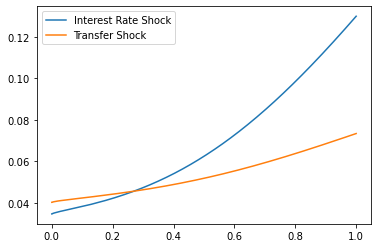

In [11]:
wealth_perc = grids.agrid(amin = 0,amax=1,n=nA)

plt.plot(wealth_perc,c_asset_dist, label = "Interest Rate Shock")
plt.plot(wealth_perc,c_asset_dist_t, label = "Transfer Shock")
plt.legend()
plt.show()